In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import gensim, spacy
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px
import pyLDAvis
import pyLDAvis.gensim_models
import warnings
warnings.filterwarnings("ignore")

In [2]:
BASE_DIR = Path.cwd().parent
stop_words = stopwords.words('english')
PALETTE = px.colors.qualitative.Prism

In [3]:
df_hosts_reviews_en = pd.read_parquet(BASE_DIR / 'processed_data' / 'hosts_reviews_en_labeled.parquet')

In [4]:
df_hosts_reviews_en = df_hosts_reviews_en.query('sentiment_label_class == 0').reset_index()

In [5]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df_hosts_reviews_en['comments'].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[0])

['stayed', 'three', 'nights', 'couldnt', 'helpful', 'soon', 'got', 'showed', 'us', 'get', 'around', 'visit', 'place', 'conveniently', 'located', 'metro', 'station', 'walking', 'distance', 'market', 'many', 'restaurants', 'clean', 'privacy', 'issue', 'despite', 'guests', 'staying', 'well', 'wifi', 'reliable', 'youre', 'vacation', 'doesnt', 'really', 'matter']


In [6]:
nlp = spacy.load("en_core_web_sm")
stop_words.append('also')
bigram = gensim.models.Phrases(data_words, min_count=1, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    #texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

# call the cached function
data_ready = process_words(data_words)

In [7]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=5,
                                           passes=5,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

lda_model.print_topics()

[(0,
  '0.028*"host" + 0.016*"apartment" + 0.014*"room" + 0.012*"stay" + 0.012*"leave" + 0.011*"bed" + 0.010*"clean" + 0.009*"get" + 0.009*"place" + 0.008*"go"'),
 (1,
  '0.025*"apartment" + 0.020*"place" + 0.019*"stay" + 0.018*"location" + 0.014*"need" + 0.011*"photo" + 0.010*"space" + 0.008*"price" + 0.007*"cosy" + 0.006*"center"')]

In [8]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,3), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['dominant_topic', 'percent_contribution', 'topic_keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    contents.name = 'text'
    sent_topics_df = (df_hosts_reviews_en.merge(sent_topics_df, left_index=True, right_index=True)
                                    .merge(contents, left_index=True, right_index=True)
                                    .drop('index', axis=1))
    return(sent_topics_df)


df_dominant_topic = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)
df_dominant_topic

,level_0,date,listing_id_encod,listing_id,reviewer_id,reviewer_name,comments,host_id,host_name,host_description,...,review_scores_location,review_scores_value,comments_language,description_language,sentiment_label,sentiment_label_class,dominant_topic,percent_contribution,topic_keywords,text
0,74,2014-06-08,2.0,1.644480e+05,13461507.0,Sherry,stayed three nights couldnt helpful soon got s...,784312.0,Li,double room central stockholm wifi renting nic...,...,4.83,4.77,en,en,-0.1869,0,1,0.580,"apartment, place, stay, location, need, photo,...","[night, couldnt_helpful, soon, get, get_around..."
1,339,2016-10-29,103.0,2.106913e+06,97097053.0,Maxim,cozy flat,10741379.0,Moa,cosy quiet studio kungsholmen set district cen...,...,4.73,4.61,en,en,0.0000,0,1,0.833,"apartment, place, stay, location, need, photo,...","[cozy, flat]"
2,345,2018-07-28,103.0,2.106913e+06,196417596.0,Elena,smallclean apartment every time,10741379.0,Moa,cosy quiet studio kungsholmen set district cen...,...,4.73,4.61,en,en,0.0000,0,1,0.594,"apartment, place, stay, location, need, photo,...","[smallclean, apartment, every_time]"
3,486,2017-03-27,105.0,2.166026e+06,110430708.0,Jerome,nothing short amazing 1010 would book thank host,4455221.0,Janu,stockholm house close fairtown cool retro vill...,...,4.70,4.74,en,en,-0.1461,0,1,0.696,"apartment, place, stay, location, need, photo,...","[short, amazing, would_book, thank, host]"
4,520,2018-08-16,105.0,2.166026e+06,116636414.0,宇星,house really big location convenient get city ...,4455221.0,Janu,stockholm house close fairtown cool retro vill...,...,4.70,4.74,en,en,0.0000,0,1,0.878,"apartment, place, stay, location, need, photo,...","[really, big, location, convenient, get_city, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,69318,2023-03-30,2697.0,7.914385e+17,446637412.0,Liliana,apartment gut located host always available qu...,493068067.0,Nazar,mysig lägenhet bright beautiful spacious apart...,...,5.00,5.00,en,en,0.0000,0,1,0.920,"apartment, place, stay, location, need, photo,...","[apartment, gut, locate, host_alway, available..."
1223,69329,2023-02-17,2640.0,7.614526e+17,27141590.0,Martynas,cosy place close city,168568871.0,Casper Fredrik,private apartment house private stylish apartm...,...,4.86,4.71,en,en,0.0000,0,1,0.869,"apartment, place, stay, location, need, photo,...","[cosy, place, close_city]"
1224,69455,2023-02-24,2723.0,8.021823e+17,286560136.0,Valerie,difficult locate reach landlord particularly s...,465046893.0,Thomas,apartment stockholm city one room apartment 28...,...,3.00,1.00,en,en,-0.0534,0,1,0.804,"apartment, place, stay, location, need, photo,...","[difficult, locate, reach, particularly, safe,..."
1225,69518,2023-03-10,2777.0,8.308865e+17,7781365.0,Lotta,wanted cancel place bed space bedding two peop...,501923445.0,Sidar,super apartment good location enjoy stylish ex...,...,4.00,3.00,en,en,-0.6705,0,0,0.870,"host, apartment, room, stay, leave, bed, clean...","[want, cancel, place, bed, space, bed, two_peo..."


In [9]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.131618  0.0       1        1  67.483193
1     -0.131618  0.0       2        1  32.516807, topic_info=             Term        Freq       Total Category  logprob  loglift
26           host  343.000000  343.000000  Default  30.0000  30.0000
34       location  109.000000  109.000000  Default  29.0000  29.0000
144          need   82.000000   82.000000  Default  28.0000  28.0000
182         photo   76.000000   76.000000  Default  27.0000  27.0000
11          place  234.000000  234.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
22      apartment  149.702697  343.321339   Topic2  -3.6737   0.2934
35           stay  111.174380  262.416380   Topic2  -3.9713   0.2646
582   appartement   23.259718   29.016651   Topic2  -5.5356   0.9023
13         really   34.732853  116.700470   Topic2  -5.1347  -0.0885
1254         thin   19.940554   27.305758   Topic2  -5.6896   0.8091

[119 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
680       1  0.095162  absolutely
680       2  0.904038  absolutely
135       1  0.165294   advertise
135       2  0.850085   advertise
267       1  0.988938      airbnb
...     ...       ...         ...
134       2  0.014111        wait
369       1  0.974733        want
369       2  0.031958        want
544       1  0.980967        work
544       2  0.018166        work

[149 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [10]:
topics = lda_model.show_topics(formatted=False)

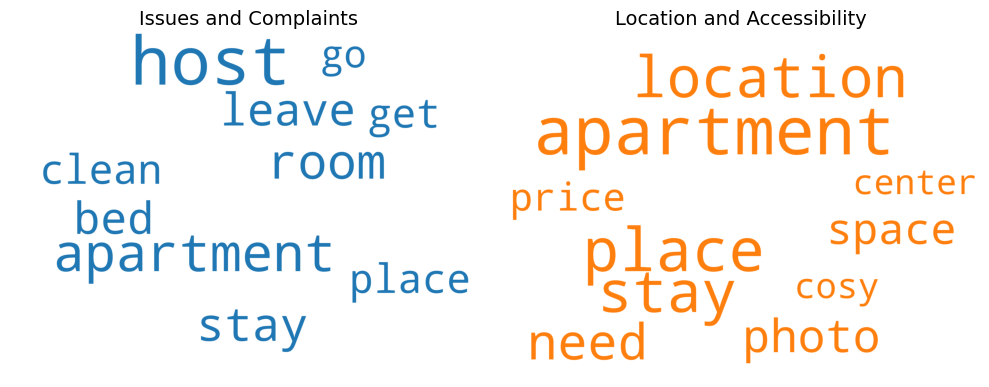

In [11]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(1, 2, figsize=(10,10), sharex=True, sharey=True)

groups = {0: 'Issues and Complaints',
          1: 'Location and Accessibility',
          2: 'Host and Service Experience'
        }

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=350)
    plt.gca().imshow(cloud)
    plt.gca().set_title(groups.get(i), fontdict=dict(size=14))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=30, hspace=10)
plt.axis('off')
#plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [12]:
numnber_topic_by_neighbourhood = (df_dominant_topic.groupby(['neighbourhood', 'dominant_topic'])
        .agg(number_of_reviews=('number_of_reviews', 'count'))
        .sort_values('number_of_reviews', ascending=False)
        .reset_index())
numnber_topic_by_neighbourhood 

,neighbourhood,dominant_topic,number_of_reviews
0,Södermalms,0,312
1,Södermalms,1,284
2,Kungsholmens,0,92
3,Norrmalms,1,77
4,Kungsholmens,1,73
5,Norrmalms,0,72
6,Enskede-Årsta-Vantörs,1,41
7,Enskede-Årsta-Vantörs,0,28
8,Östermalms,0,22
9,Hägersten-Liljeholmens,0,22


In [13]:
# Define a custom color mapping function
def get_tile_color(tile_path):
    # Get the name of the neighbourhood and the dominant topic from the tile path
    neighbourhood, dominant_topic = tile_path[-2:]

    # Assign a specific color to each combination of neighbourhood and dominant topic
    if dominant_topic == 'topic 0' and neighbourhood == 'Neighbourhood 1':
        return 'red'
    elif dominant_topic == 'topic 1' and neighbourhood == 'Neighbourhood 2':
        return 'green'
    else:
        # Use the default color scale for all other tiles
        return None

# Create the treemap with the custom color mapping function
fig = px.treemap(
    numnber_topic_by_neighbourhood,
    path=['neighbourhood', 'dominant_topic'],
    values='number_of_reviews',
    color_discrete_sequence=PALETTE,
    color_continuous_midpoint=np.average(numnber_topic_by_neighbourhood['number_of_reviews']),
)

# Apply the custom color mapping function to each tile
fig.data[0].marker.colors = [get_tile_color(tile_path) for tile_path in fig.data[0].ids]

# Show the figure
fig.show()